Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [308]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import lab9_lib
import sys
import math

from tqdm import tqdm
from dataclasses import dataclass
from copy import deepcopy
from collections import deque

## Numeric Values

In [309]:
INSTANCES = [1, 2, 5, 10] 
LOCI_GENOMES = 1000 # the lenght of the genotype

POPULATION_SIZE = 100 # the size of the entire population
TOURNAMENT_SIZE = 30 # the amount of individuals the selection of the parents will me made on
OFFSPRINGS = 50 # amount of offsprings per each generation
MAX_GENERATIONS = 1000 # numebr of generations at most (unless we find an optimum before)
MAX_CUT_POINTS = 10 # maximum number of cutting points in a xover (they're random)
MIN_CUT_POINTS = 2
# TABU_LENGHT = 8196*4 # ~4kb # tabu table size
# MUTATION_PROBABILITY = .8
# XOVER_PROBABILITY = .5 # probability of chosing n_cut_xover rather than one_cut_xover
# N_CUT_XOVER_PROB = .8

ISLANDS = 1 # number of islands
START_POPULATION_ISLAND = int(POPULATION_SIZE/ISLANDS)
MAX_POPULATION_ISLAND = START_POPULATION_ISLAND + int(START_POPULATION_ISLAND/4)
MIGRATION_RATE = 100 # after how many generations we have a migration
MIGRANTS = 5 # number of migrants
ISLANDS_COLORS = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

SIM_ANEAL_RATE = 50 # after how many generations of flatness the simulated_aneling can start
STALE_MATE_RATE = 200 # after how many generations is not worth continuing searching if we're stuck
SIMULATED_ANEALING_DURATION = 50 # how many generations simulated anealing last
TEMPERATURE = 1e-2
THRESHOLD_IMPROVEMENT = 1e-3

## Evolutionary Strategy Functions

In [310]:
@dataclass
class Individual:
    genotype: list[bool]
    fitness: float

    def __str__(self):
        return f"{self.genotype}: {self.fitness:.2%}"

    def fitness(self) -> float:
        return fitness

def mutation(ind: Individual) -> None:
    # strength =  math.ceil((LOCI_GENOMES - sum(ind.genotype)) / 20) # number of zeros / 20
    genes = rnd.sample([i for i in range(LOCI_GENOMES)], 1)
    
    for g in genes:
        ind.genotype[g] = 1 - ind.genotype[g] 

    # gene = rnd.choice([i for i in range(LOCI_GENOMES)])
    # ind.genotype[gene] = 1 - ind.genotype[gene] 
    # ind.fitness = None

def one_cut_xover(ind1: Individual, ind2: Individual) -> Individual:
    cut_point = int(len(ind1.genotype) / 2)
    offspring = Individual(genotype=np.concatenate((ind1.genotype[:cut_point], ind2.genotype[cut_point:]), axis=None), fitness=None)
    return offspring

def n_cut_xover(ind1: Individual, ind2: Individual, cuts: int) -> Individual:
    cut_points = np.linspace(0, LOCI_GENOMES, cuts + 1, dtype=int)
    inds = (ind1, ind2)
    ind_turn = 0
    prev_cut_point = 0
    offspring = Individual(genotype=np.zeros(LOCI_GENOMES), fitness=None)

    for cut in cut_points:
        offspring.genotype[prev_cut_point:cut] = inds[ind_turn].genotype[prev_cut_point:cut]
        prev_cut_point = cut
        ind_turn = 1 - ind_turn

    assert len(offspring.genotype) == LOCI_GENOMES

    return offspring

def select_parent(population: list) -> Individual:
    pool = [rnd.choice(population) for _ in range(TOURNAMENT_SIZE)]
    champion = max(pool, key=lambda i: i.fitness)
    return champion

## Tabu Table

In [311]:
# Tabu table will remember if a recent state was already been anlized
# When the table is full it removes the oldest state that was analized
# The dimension of the table is a cruicial and though parameter to decide

@dataclass
class TabuCache:
    table: deque

    def __init__(self, size) -> None:
        self.table = deque(maxlen=size)

    def tabu_add(self, state: list) -> bool:
        try:
            hit = False
            if self.table.index(state) >= 0:
                self.table.remove(state)
                hit = True
        except ValueError:
            pass
        finally:
            self.table.append(state)
        
        return hit

    def get_table(self) -> deque:
        return self.table


## Population Generation

In [312]:
def generate_population(fitness) -> (list):
    population = list()
    genotypes = list()

    # generate different individuals
    for i in range(POPULATION_SIZE):
        new_genotype = rnd.choices([0, 1], k=LOCI_GENOMES)
        while new_genotype in genotypes:
            new_genotype = rnd.choices([0, 1], k=LOCI_GENOMES)

        genotypes.append(new_genotype)
        population.append(Individual(genotype=new_genotype, fitness=None))
        
    for i in population:
        i.fitness = fitness(i.genotype)

    return population


## Divide in Islands

In [313]:
# We should divide the starting population into different islands
# representing different isolated environments.
# Migrations are allowd sporadically

def generate_islands(population: list) -> list:
    islands = list()
    slice_points = np.linspace(0, POPULATION_SIZE, ISLANDS + 1, dtype=int)

    for isl in range(ISLANDS):
        islands.append(population[slice_points[isl]:slice_points[isl+1]])

    return islands

## Simulated Annealing

In [314]:
def prob(f1: float, f2: float, temp: float):
    return np.exp(-(f1-f2)/temp)

## Training

Problem with instance: 1


  1%|          | 11/1000 [00:00<00:09, 104.69it/s]

 31%|███       | 306/1000 [00:02<00:06, 115.42it/s]


Reached fitness maximum before 1000 generations!
Best fitness: 1.0
Fitness calls: 15450
Problem with instance: 2


100%|██████████| 1000/1000 [00:08<00:00, 115.75it/s]


Best fitness: 0.998
Fitness calls: 50100
Problem with instance: 5


 40%|████      | 400/1000 [00:03<00:05, 111.09it/s]


Couldn't improve in the last 200 generations :(
Best fitness: 0.327
Fitness calls: 20150
Problem with instance: 10


 40%|████      | 400/1000 [00:03<00:05, 107.60it/s]


Couldn't improve in the last 200 generations :(
Best fitness: 0.168
Fitness calls: 20150


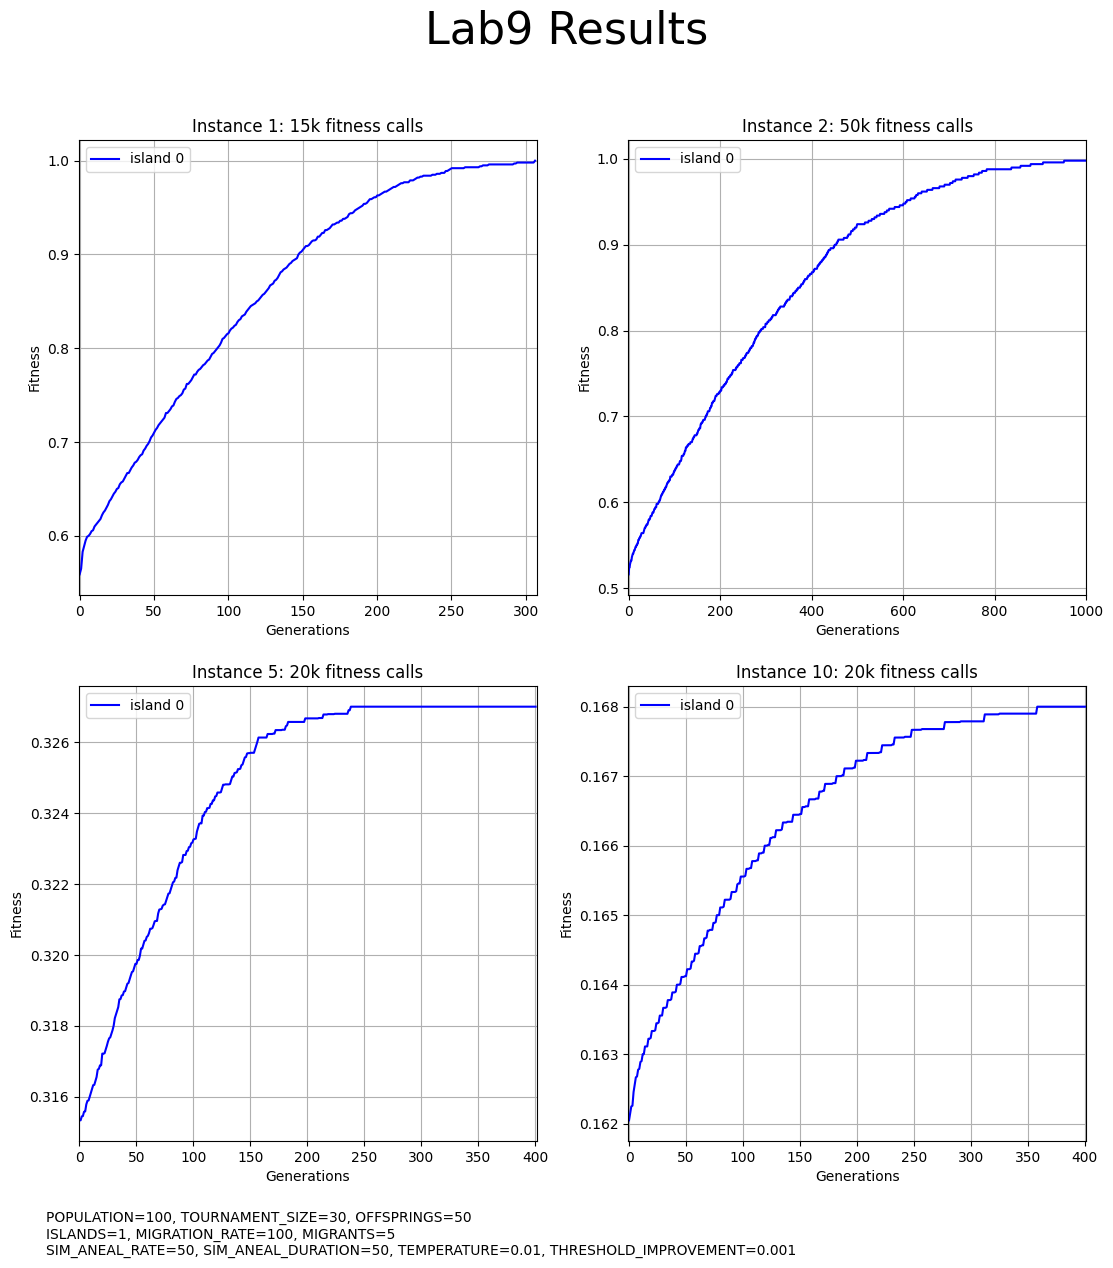

In [315]:
# for the graphs
fig, axes = plt.subplots(2, 2, figsize=(13, 13))
x = np.linspace(0, MAX_GENERATIONS, MAX_GENERATIONS)
y = [np.zeros(MAX_GENERATIONS) for _ in range(ISLANDS)]
last_gen = None

for idx, inst in enumerate(INSTANCES):
    print(f"Problem with instance: {inst}")

    # setting starting point for algorithm
    fitness = lab9_lib.make_problem(inst)
    population = generate_population(fitness)
    islands = generate_islands(population)
    islands_popultaion = [START_POPULATION_ISLAND for _ in range(ISLANDS)]
    start_sim_aneal = np.zeros(ISLANDS)
    simulated_anealing = [False for _ in range(ISLANDS)]
    activation_sim_aneal = [list() for _ in range(ISLANDS)]
    stale_mate = [False for _ in range(ISLANDS)]
    last_gen = MAX_GENERATIONS

    for gen in tqdm(range(MAX_GENERATIONS)):

        # after each MIGRATION_RATE generations:
        # migrate MIGRANTS individuals from an island to the next one
        if gen != 0 and gen % MIGRATION_RATE == 0:
            migrants = list()
            for isl in range(ISLANDS):
                migrants.append(islands[isl][:MIGRANTS])

            # circular migration
            for isl in range(ISLANDS):
                if isl == ISLANDS- 1:
                    islands[0][:MIGRANTS] = migrants[isl]
                else:
                    islands[isl + 1][:MIGRANTS] = migrants[isl]

        for isl in range(ISLANDS):
            offsprings = list()

            # when the duration of simulated anealing is over repristinate starting_population_islands
            if simulated_anealing[isl] and gen - start_sim_aneal[isl] > SIMULATED_ANEALING_DURATION:
                simulated_anealing[isl] = False
                islands_popultaion[isl] = START_POPULATION_ISLAND
                islands[isl] = islands[isl][:START_POPULATION_ISLAND]

            # generate OFFSPRINGS offsprings
            for _ in range(OFFSPRINGS):
                p1 = select_parent(islands[isl])

                # if we're dealing with simulated anealing we have to select a parent from the worse individuals
                if simulated_anealing[isl]:
                    p2 = rnd.choice(islands[isl])
                else:
                    p2 = select_parent(islands[isl])

                o = n_cut_xover(p1, p2, rnd.choice([k for k in range(MIN_CUT_POINTS, MAX_CUT_POINTS)]))
                mutation(o)

                offsprings.append(o)

            # caluclate fintess on offsprings
            for o in offsprings:
                o.fitness = fitness(o.genotype)

            # extend population with offsprings
            islands[isl].extend(offsprings)
            islands[isl].sort(key=lambda i: i.fitness, reverse=True)

            # if simulated anelaing is on we need to keep the discarded individual so we can put them back again
            if simulated_anealing[isl]:
                discarded = islands[isl][islands_popultaion[isl]:]

            # save the best individuals and their worst one
            islands[isl] = islands[isl][:islands_popultaion[isl]]
            worst = islands[isl][-1]

            # simulated anealing : keep some worse offspring
            if simulated_anealing[isl]:
                for d in discarded:
                    wf = worst.fitness
                    df = d.fitness
                    if islands_popultaion[isl] < MAX_POPULATION_ISLAND and wf != df and rnd.random() < prob(wf, df, TEMPERATURE):
                        islands[isl].append(d)
                        islands_popultaion[isl] += 1

            # if fitness reach 1 then stop algorithm
            if islands[isl][0].fitness == 1:
                last_gen = gen + 1

            # updating graph
            y[isl][gen] = islands[isl][0].fitness

            #each STALE_MATE generations:
            # check if the island is at a point in which the fitness doesn't improve
            if gen != 0 and gen % STALE_MATE_RATE == 0:
                delta_fitness = y[isl][gen] - y[isl][gen - STALE_MATE_RATE]
                if delta_fitness < THRESHOLD_IMPROVEMENT:
                    stale_mate[isl] = True
                else:
                    stale_mate[isl] = False

            # each DELTA_GENERATIONS generations:
            # if simulated anealing is off and we see that we're not improving => activate it
            if gen != 0 and gen % SIM_ANEAL_RATE == 0:
                delta_fitness = y[isl][gen] - y[isl][gen - SIM_ANEAL_RATE]
                if simulated_anealing[isl] == False and delta_fitness < THRESHOLD_IMPROVEMENT:
                    # try starting simulated anealing
                    simulated_anealing[isl] = True
                    activation_sim_aneal[isl].append(gen)
                    start_sim_aneal[isl] = gen

        # we don't go to the next generation if we reached 1 as fitness before the max amount of gens (last_gen < MAX_GENERATIONS)
        if last_gen < MAX_GENERATIONS:
            print(f"Reached fitness maximum before {MAX_GENERATIONS} generations!")
            break

        # if all islands are in a stalemate => terminate
        if all(stale_mate):
            last_gen = gen + 1
            print(f"Couldn't improve in the last {STALE_MATE_RATE} generations :(")
            break

    # decretating the winner among all islands
    final_population = list()
    for isl in range(ISLANDS):
        final_population += islands[isl]
    final_population.sort(key=lambda i: i.fitness, reverse=True)

    print(f"Best fitness: {final_population[0].fitness}")
    print(f"Fitness calls: {fitness.calls}")
    plt.subplot(2, 2, idx + 1)
    plt.title(f"Instance {inst}: {int(fitness.calls/1e3)}k fitness calls")
    plt.grid()
    plt.xlabel('Generations')
    plt.ylabel('Fitness')
    plt.xlim(-0.5, last_gen + 0.5)

    for isl in range(ISLANDS):
        for line_x in activation_sim_aneal[isl]:
            plt.axvline(x = line_x, color = ISLANDS_COLORS[isl], ls="--")

    for isl in range(ISLANDS):
        plt.plot(x[:last_gen], y[isl][:last_gen], label=f"island {isl}", color=ISLANDS_COLORS[isl])

    plt.legend()

fig.suptitle("Lab9 Results", fontsize=32)
info_text = f"POPULATION={POPULATION_SIZE}, TOURNAMENT_SIZE={TOURNAMENT_SIZE}, OFFSPRINGS={OFFSPRINGS}\nISLANDS={ISLANDS}, MIGRATION_RATE={MIGRATION_RATE}, MIGRANTS={MIGRANTS}\nSIM_ANEAL_RATE={SIM_ANEAL_RATE}, SIM_ANEAL_DURATION={SIMULATED_ANEALING_DURATION}, TEMPERATURE={TEMPERATURE}, THRESHOLD_IMPROVEMENT={THRESHOLD_IMPROVEMENT}"
fig.text(0.1, 0.02, info_text, ha='left', va='bottom', fontsize=10, transform=fig.transFigure)
plt.savefig(f"lab9_results_{ISLANDS}islands.png")